# BRISQUE score

## single image

In [ ]:
#BRISQUE
#Blind/Referenceless Image Spatial Quality Evaluator
#Single number score for image quality (to facilitate comparing photos and selecting 'best' photo)

'''
add to requirements.txt !!!!!!! _> #pip install brisque
'''
#pip install brisque

from PIL import Image
import numpy as np
from brisque import BRISQUE

# Load the image using PIL
image_path = '/home/gregrevill/code/GregRevFr/photopocalypse/raw_data/input_images/DSC_0797.JPG'
image = Image.open(image_path)

# Convert the image to RGB (if it's not already)
image = image.convert('RGB')

# Convert the image to a numpy array
image_array = np.array(image)

# Calculate the BRISQUE score
brisque_score = BRISQUE().score(image_array)

print(f"BRISQUE score for the image is: {brisque_score}")

#For Image via URL :
#obj = BRISQUE(url=True).score("https://images.ctfassets.net/u4vv676b8z52/4dy4qSI9G77nmLayGrUl73/08fdde4d35a717c7e9d123ef2a478e9b/blurred-vision-678x446_compressed.jpg?fm=jpg&q=80")


## BRISQUE score for multiple images in a folder (with error avoidance code)

In [ ]:
import os
from PIL import Image
import numpy as np
from brisque import BRISQUE
import pandas as pd

# Function to process a single image
def process_image(image_file):
    # Construct the full image path
    image_path = os.path.join(image_dir, image_file)

    # Check if the path is a file and is a recognized image format
    if os.path.isfile(image_path) and image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        try:
            # Load the image using PIL
            image = Image.open(image_path)

            # Convert the image to RGB (if it's not already)
            image = image.convert('RGB')

            # Resize the image
            image = image.resize((256, 256))

            # Convert the image to a numpy array
            image_array = np.array(image)

            # Calculate the BRISQUE score
            brisque_score = BRISQUE().score(image_array)

            return (image_file, brisque_score)
        except Exception as e:
            print(f"Error processing file {image_file}: {e}")

# Directory containing the images
image_dir = "/home/gregrevill/code/GregRevFr/photopocalypse/raw_data/input_images/"

# List all the files in the directory
image_files = os.listdir(image_dir)

# Initialize a list to store the results
results = []

# Process each image file
for image_file in image_files:
    result = process_image(image_file)
    if result is not None:
        results.append(result)

# Convert the results to a pandas DataFrame
df = pd.DataFrame(results, columns=['Image', 'BRISQUE Score'])

# Display the DataFrame
print(df)


In [ ]:
df.to_csv('/home/gregrevill/code/GregRevFr/photopocalypse/raw_data/brisque_scores2.csv')

# Tiling for Deblur model

In [5]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import cv2

model_path = '/home/gregrevill/code/GregRevFr/photopocalypse/models/SRresnet-from-kaggle-trained-on-blur.h5'
image_path = '/home/gregrevill/code/GregRevFr/photopocalypse/raw_data/input_images/boy_champagne_resized_256x256.jpg'
model = load_model(model_path)

# Load the image
image = cv2.imread(image_path)

# Expand dimensions to represent a batch of size 1
image = np.expand_dims(image, axis=0)

# Enhance image
enhanced_image = model.predict(image)

# Convert the float array to integer
enhanced_image = enhanced_image.astype(np.uint8)

# Remove the extra dimension
enhanced_image = np.squeeze(enhanced_image, axis=0)

# save enhanced image to output folder
output_folder = '/home/gregrevill/code/GregRevFr/photopocalypse/raw_data/output_images/'
new_filename = 'SRresnet_champagne_boy_256x256.jpg'
output_path = os.path.join(output_folder, new_filename)
cv2.imwrite(output_path, enhanced_image)

1/1 [==============================] - 2s 2s/step


True

In [10]:
# deblur folder from github archive

import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import cv2

model_path = '/home/gregrevill/code/GregRevFr/photopocalypse/models/SRresnet-from-kaggle-trained-on-blur.h5'
image_path = '/home/gregrevill/code/GregRevFr/photopocalypse/raw_data/input_images/boy_champagne_resized_256x256.jpg'
model = load_model(model_path)
tile_size = 256
number_of_tiles = 9

def deblur_image(image_path):
    # Load the image
    image = cv2.imread(image_path)

    # Save the original dimensions
    original_height, original_width = image.shape[:2]

    # Resize if larger than 768x768
    max_side = tile_size * int(number_of_tiles ** 0.5)
    scale_factor = min(max_side / image.shape[0], max_side / image.shape[1])
    if scale_factor < 1:
        new_size = (int(image.shape[1] * scale_factor), int(image.shape[0] * scale_factor))
        image = cv2.resize(image, new_size, interpolation=cv2.INTER_AREA)

    # Padding
    pad_height = (tile_size - image.shape[0] % tile_size) % tile_size
    pad_width = (tile_size - image.shape[1] % tile_size) % tile_size
    image = cv2.copyMakeBorder(image, 0, pad_height, 0, pad_width, cv2.BORDER_CONSTANT, value=0)

    # Split into tiles
    tiles = []
    for i in range(0, image.shape[0], tile_size):
        for j in range(0, image.shape[1], tile_size):
            tile = image[i:i + tile_size, j:j + tile_size]
            tiles.append(tile)

    # Predict and enhance each tile
    enhanced_tiles = [model.predict(np.expand_dims(tile, 0))[0] for tile in tiles]

    # Reconstruct the enhanced image
    rows = []
    for i in range(0, len(enhanced_tiles), int(image.shape[1] / tile_size)):
        rows.append(np.hstack(enhanced_tiles[i:i + int(image.shape[1] / tile_size)]))
    enhanced_image = np.vstack(rows)

    # Remove padding
    enhanced_image = enhanced_image[:original_height, :original_width]
    return enhanced_image

# Deblur the image
image_path = '/home/gregrevill/code/GregRevFr/photopocalypse/raw_data/input_images/boy_champagne_resized_256x256.jpg'
enhanced_image = deblur_image(image_path)

# Save the enhanced image
output_folder = '/home/gregrevill/code/GregRevFr/photopocalypse/raw_data/output_images/'
new_filename = 'SRresnet_champagne_boy_256x256_12h.jpg'
output_path = os.path.join(output_folder, new_filename)
cv2.imwrite(output_path, enhanced_image)

1/1 [==============================] - 2s 2s/step


True

In [11]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import cv2

model_path = '/home/gregrevill/code/GregRevFr/photopocalypse/models/SRresnet-from-kaggle-trained-on-blur.h5'
image_path = '/home/gregrevill/code/GregRevFr/photopocalypse/raw_data/input_images/boy_champagne_resized_256x256.jpg'
output_folder = '/home/gregrevill/code/GregRevFr/photopocalypse/raw_data/output_images/'
new_filename = 'SRresnet_champagne_boy_256x256.jpg'

# Check if model and image files exist
if not os.path.exists(model_path):
    print(f"Model file not found: {model_path}")
    exit()
if not os.path.exists(image_path):
    print(f"Image file not found: {image_path}")
    exit()

# Load the model
model = load_model(model_path)

# Load and preprocess the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
image = image / 255.0  # Normalize to [0, 1]

# Expand dimensions to represent a batch of size 1
image_batch = np.expand_dims(image, axis=0)

# Enhance image
enhanced_image = model.predict(image_batch)

# Post-process the output
enhanced_image = np.clip(enhanced_image, 0, 1)  # Ensure values are within [0, 1]
enhanced_image = (enhanced_image * 255).astype(np.uint8)  # Rescale to [0, 255] and convert to uint8
enhanced_image = np.squeeze(enhanced_image, axis=0)  # Remove batch dimension

# Convert back to BGR for saving with OpenCV
enhanced_image_bgr = cv2.cvtColor(enhanced_image, cv2.COLOR_RGB2BGR)

# Create output directory if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Save enhanced image
output_path = os.path.join(output_folder, new_filename)
cv2.imwrite(output_path, enhanced_image_bgr)

print(f"Enhanced image saved to {output_path}")


1/1 [==============================] - 3s 3s/step
Enhanced image saved to /home/gregrevill/code/GregRevFr/photopocalypse/raw_data/output_images/SRresnet_champagne_boy_256x256.jpg


### deblur single image

In [19]:
'''
Model to deblur images, using EDSR.
if the input image is larger than 768x768 then it scales the image down so longest side is 768 pixels,
then pads short side to reach 768 pixels,
then splits padded image into 9 tiles,
process each tile individually,
then reconstruct the enhanced image from the enhanced patches
and remove padding from the enhanced image.
'''

import os
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import cv2

# initial model_path = '/home/gregrevill/code/GregRevFr/photopocalypse/models/SRresnet-from-kaggle-trained-on-blur.h5'
# paulo model model_path = '/home/gregrevill/code/GregRevFr/photopocalypse/models/EDSR_blur_dataset_model_2.h5'
# latest model_path = '/home/gregrevill/code/GregRevFr/photopocalypse/models/gen_model3000.h5'
image_path = '/home/gregrevill/code/GregRevFr/photopocalypse/raw_data/input_images/champboy/boy_champagne_resized_1024x1024.jpg'
model = load_model(model_path)
tile_size = 256
number_of_tiles = 16

def deblur_image(image_path):
    # Load the image
    image = cv2.imread(image_path)

    # Resize if larger than 768x768
    max_side = tile_size * int(number_of_tiles ** 0.5)
    scale_factor = min(max_side / image.shape[0], max_side / image.shape[1])
    if scale_factor < 1:
        new_size = (int(image.shape[1] * scale_factor), int(image.shape[0] * scale_factor))
        image = cv2.resize(image, new_size, interpolation=cv2.INTER_AREA)

    # Padding
    original_height, original_width = image.shape[:2]
    pad_height = (tile_size - image.shape[0] % tile_size) % tile_size
    pad_width = (tile_size - image.shape[1] % tile_size) % tile_size
    image = cv2.copyMakeBorder(image, 0, pad_height, 0, pad_width, cv2.BORDER_CONSTANT, value=0)

    # Split into tiles
    tiles = []
    for i in range(0, image.shape[0], tile_size):
        for j in range(0, image.shape[1], tile_size):
            tile = image[i:i + tile_size, j:j + tile_size]
            tiles.append(tile)

    # Predict and enhance each tile
    enhanced_tiles = [(model.predict(np.expand_dims(tile / 255., 0)) * 255)[0].astype(np.uint8) for tile in tiles]

    # Reconstruct the enhanced image
    rows = []
    for i in range(0, len(enhanced_tiles), int(image.shape[1] / tile_size)):
        rows.append(np.hstack(enhanced_tiles[i:i + int(image.shape[1] / tile_size)]))
    enhanced_image = np.vstack(rows)

    # Remove padding
    enhanced_image = enhanced_image[:original_height + pad_height, :original_width + pad_width]

    # Now crop back to original size
    enhanced_image = enhanced_image[:original_height, :original_width]

    return enhanced_image

# save enhanced image to output folder
output_folder = '/home/gregrevill/code/GregRevFr/photopocalypse/raw_data/output_images/'
new_filename = 'SRresnet_champagne_boy_1024x1024vbig.jpg'
output_path = os.path.join(output_folder, new_filename)

# Call the deblur_image function and save the result
enhanced_image = deblur_image(image_path)
cv2.imwrite(output_path, enhanced_image)

1/1 [==============================] - 2s 2s/step


True

### display two images side by side

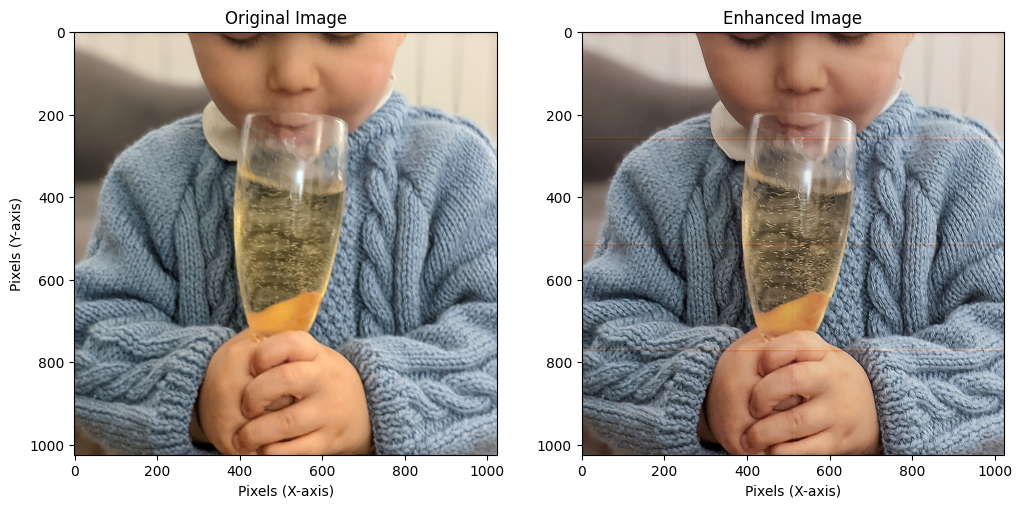

In [20]:
# display original image and super resolution image side by side with labels

import matplotlib.pyplot as plt
import cv2

# Load the original and enhanced images
original_image = cv2.imread('/home/gregrevill/code/GregRevFr/photopocalypse/raw_data/input_images/champboy/boy_champagne_resized_1024x1024.jpg')
enhanced_image = cv2.imread('/home/gregrevill/code/GregRevFr/photopocalypse/raw_data/output_images/SRresnet_champagne_boy_1024x1024vbig.jpg')

# Convert images from BGR to RGB for correct color representation
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
enhanced_image = cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2RGB)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot original image
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[0].set_xlabel('Pixels (X-axis)')
axes[0].set_ylabel('Pixels (Y-axis)')
axes[0].axis('on')  # Display the axis

# Plot enhanced image
axes[1].imshow(enhanced_image)
axes[1].set_title('Enhanced Image')
axes[1].set_xlabel('Pixels (X-axis)')
axes[1].axis('on')  # Display the axis

# Show the plot
plt.show()


### Resize single image to square

In [1]:
# resize single image to square

import cv2

def resize_and_save_image(image_path, output_folder, sizes):
    """
    Resizes an image to multiple sizes and saves them.
    """
    # Read the original image
    image = cv2.imread(image_path)

    if image is None:
        print("Error: Image not found.")
        return

    for size in sizes:
        # Resize the image
        resized_image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)

        # Construct the output file path
        output_path = f"{output_folder}/2_{size[0]}x{size[1]}.jpg"

        # Save the resized image
        cv2.imwrite(output_path, resized_image)
        print(f"Image saved to {output_path}")

# Example usage
image_path = '/home/gregrevill/code/GregRevFr/photopocalypse/raw_data/input_images/boy_champagne_resized_4096x4096.jpg'
output_folder = "/home/gregrevill/code/GregRevFr/photopocalypse/raw_data/input_images/"  # Replace with your desired output folder
sizes = [(256, 256)]  # Different sizes for testing

resize_and_save_image(image_path, output_folder, sizes)


Image saved to /home/gregrevill/code/GregRevFr/photopocalypse/raw_data/input_images//2_256x256.jpg


### Resize images to 600x600

In [58]:
# resizes folder of images to 600x600

import os
import cv2

def resize_image(image_path, output_dir, size=(600, 600)):
    if not os.path.isfile(image_path) or not image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
        return

    try:
        image = cv2.imread(image_path)
        height, width, channels = image.shape

        if height > width:
            image = image[0:width, 0:width] # crops from the bottom to make square

        resized_image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
        output_path = os.path.join(output_dir, os.path.basename(image_path))
        cv2.imwrite(output_path, resized_image)
    except Exception as e:
        print(f"Error processing file {image_path}: {e}")

image_dir = "/home/gregrevill/code/GregRevFr/photopocalypse/raw_data/input13"
output_dir = "/home/gregrevill/code/GregRevFr/photopocalypse/raw_data/input_images/input13_600x600"

os.makedirs(output_dir, exist_ok=True)

for image_file in os.listdir(image_dir):
    image_path = os.path.join(image_dir, image_file)
    resize_image(image_path, output_dir)

### Score Bluriness & sharpness of folder of images

In [5]:
# code to score images in folder with blurr_model.h5

import os
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import pandas as pd

model_path = '/home/gregrevill/code/GregRevFr/photopocalypse/models/blurr_model.h5'
image_dir = "/home/gregrevill/code/GregRevFr/photopocalypse/raw_data/input_images/input13_600x600"

model = load_model(model_path)

def score_image(image_path):
    # Load the image
    image = cv2.imread(image_path)

    # Convert the image to RGB (if it's not already)
    if len(image.shape) == 3 and image.shape[2] == 3:  # Check if the image has 3 channels
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize the image
    image = cv2.resize(image, (600, 600))

    # Convert the image to a numpy array
    image_array = np.array(image)

    # Calculate the bluriness & sharpness scores
    blurr_scores = model.predict(np.expand_dims(image_array, axis=0))

    return (image_path, blurr_scores)

# List all the files in the directory
image_files = os.listdir(image_dir)

# Initialize a list to store the results
results = []

# Process each image file
for image_file in image_files:
    result = score_image(os.path.join(image_dir, image_file))
    if result is not None:
        results.append(result)

# Convert the results to a pandas DataFrame
df = pd.DataFrame(results, columns=['Image', 'Blurr Score'])


1/1 [==============================] - 0s 103ms/step


In [7]:
# modify df to split "score" into "blur_score" and "sharpness_score"
df[['blur_score', 'sharpness_score']] = pd.DataFrame(df['Blurr Score'].apply(lambda x: x[0]).tolist(), index=df.index)
df = df.drop(columns=['Blurr Score'])

# display df
print(df)

# save df to csv
df.to_csv('/home/gregrevill/code/GregRevFr/photopocalypse/raw_data/blurr_scores13_600x600.csv')

                                                Image  blur_score  \
0   /home/gregrevill/code/GregRevFr/photopocalypse...    0.690235   
1   /home/gregrevill/code/GregRevFr/photopocalypse...    0.928970   
2   /home/gregrevill/code/GregRevFr/photopocalypse...    0.548703   
3   /home/gregrevill/code/GregRevFr/photopocalypse...    0.996541   
4   /home/gregrevill/code/GregRevFr/photopocalypse...    0.789117   
5   /home/gregrevill/code/GregRevFr/photopocalypse...    0.353661   
6   /home/gregrevill/code/GregRevFr/photopocalypse...    0.978138   
7   /home/gregrevill/code/GregRevFr/photopocalypse...    0.944686   
8   /home/gregrevill/code/GregRevFr/photopocalypse...    0.688397   
9   /home/gregrevill/code/GregRevFr/photopocalypse...    0.900265   
10  /home/gregrevill/code/GregRevFr/photopocalypse...    0.936554   
11  /home/gregrevill/code/GregRevFr/photopocalypse...    0.706309   
12  /home/gregrevill/code/GregRevFr/photopocalypse...    0.343328   

    sharpness_score  
0          

In [3]:
#plot the results in histogram

import matplotlib.pyplot as plt
import pandas as pd


# scatter plot with image name on x axis and blur score on y axis and point size based on sharpness score and point labels image name
plt.figure(figsize=(15, 10))
plt.scatter(df2.index, df2['blur_score'])
plt.title('Blurriness Scores')
plt.xlabel('Image')
plt.ylabel('Blurriness Score')
plt.xticks(df2.index, df['Image'], rotation=90)
plt.show()


KeyError: 'blur_score'

<Figure size 1500x1000 with 0 Axes>